In [31]:
import os, time
import pandas as pd
#import codecs
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, Dataset
import spacy
import random

### Loading the data

In [32]:
nlp = spacy.load('en_core_web_sm')

In [35]:
df = pd.read_csv('/kaggle/input/filtered-data/job_desc_filtered_skills_andsoft.csv')
df = df[0:20000]
df = df[~df['sentence'].isna()].reset_index()
df.head()

,index,Unnamed: 0,sentence,TECHNICAL,TECHNOLOGY,skills,filtered_skills,soft_skills
0,0,0,job description as a junior data scientist at ...,"['machine learning', 'modeling', 'algorithms',...","['python', 'hadoop']","machine learning, modeling, algorithms, probab...","data preparation, algorithms, linear algebra, ...","['collaborative', 'presentation skills', 'comm..."
1,1,1,data scientist provides the credentials and ca...,"['data science', 'methodology', 'case studies']",[],"data science, methodology, case studies","case studies, data science","['learning', 'on the job', 'learning', 'learni..."
2,2,2,"re just getting your career started , and we ’...","['mathematics', 'data science']",['go'],"mathematics, data science, go","go, mathematics, data science","['learning', 'problem solving', 'critical thin..."
3,3,3,"skills roadmap , learning and demonstrating ne...",['statistics'],"['java', 'javascript', 'php', 'c', 'c', 'c', '...","statistics, java, javascript, php, c, c, c, c,...","c, php, java, javascript, statistics, programm...","['learning', 'training and development', 'lear..."
4,4,4,is committed to creating a diverse environment...,[],[],NaN,NaN,[]


### Converting the data to BIO tags notation

In [36]:
def get_tags(job, skills):
    try:
        doc = nlp(job)
    except:
        print(job)
    tokens  = [str(i) for i in doc]
    tags = ['O' for i in tokens]
    if type(skills) != float:
        try:
            skills = [i.strip() for i in skills.split(',')]
        except:
            print(skills)
        for skill in skills:
            for i, token in enumerate(tokens):
                if token == skill:
                    tags[i] = 'B'
                unigrams = skill.split()
                if len(unigrams) > 1:
                    if i< len(tokens)-1 and token == unigrams[0] and tokens[i+1] == unigrams[1]:
                        tags[i] = 'B'
                        tags[i+1] = 'I'
    return tokens, tags

In [37]:
tokens, tags = get_tags(df['sentence'][0],  df['filtered_skills'][0])

for token, tag in zip(tokens, tags):
    if tag in {'B', 'I'}:
        print(token, tag)

In [38]:
all_tokens = []
all_tags = []
for job, skills in tqdm(zip(df['sentence'], df['filtered_skills'])):
    tokens, tags = get_tags(job, skills)
    all_tokens.append(tokens)
    all_tags.append(tags)

20000it [09:22, 35.53it/s]


#### Limiting the input token length to 200 tokens

In [39]:
# Finding the longest sentence
LONGEST_SENTENCE = 200
LONGEST_SENTENCE

200

In [40]:
input_tokens, output_tags = [], []
for i, j in zip(all_tokens, all_tags):
    if len(i) <= LONGEST_SENTENCE:
        input_tokens.append(i)
        output_tags.append(j)
len(input_tokens)

6900

In [41]:
def pad_tokens(input_tokens, longest_sentence):
    padded = []
    for sent in input_tokens:
        padding = ["<null>" for i in range(longest_sentence - len(sent))]
        padded.append(sent + padding)
    return padded

def pad_tags(output_tags, longest_sentence):
    padded = []
    for sent in output_tags:
        padding = [ "<null>" for i in range(longest_sentence - len(sent))]
        padded.append(sent + padding)
    return padded


In [42]:
padded_input_tokens = pad_tokens(input_tokens[0:1], LONGEST_SENTENCE) 
padded_output_tags = pad_tags(output_tags[0:1], LONGEST_SENTENCE)

assert len(padded_input_tokens[0]) == LONGEST_SENTENCE
assert len(padded_output_tags[0]) == LONGEST_SENTENCE
assert padded_input_tokens[0][-1] == "<null>"
assert padded_output_tags[0][-1] == "<null>" 
print('Success!')

Success!


Now, we need to vectorize our input vocabulary and output tags. The code below creates a number of global variables to help us with this. 

* The `WORD_TO_IDX` dictionary maps words occurring in the training data into unique integers. 
* The `TAG_TO_IDX` dictionary maps *every* tag in our data to a unique integer. 
* The `IDX_TO_TAG` dictionary maps the other way so you can decode tags later.

In [43]:
PAD = "<null>"
UNK = "<unk>"

words = set([word for sent_words in input_tokens for word in sent_words])

# Padding and unknown token
words.add(PAD)
words.add(UNK)

tags = list(set([tag for sent_tags in output_tags for tag in sent_tags]))

# Padding tag
tags.append(PAD)

WORD_TO_IDX = {w:i for i,w in enumerate(words)}
TAG_TO_IDX = {t:i for i,t in enumerate(tags)}
IDX_TO_TAG = tags

In [44]:
len(WORD_TO_IDX)

17683

In [45]:
TAG_TO_IDX

{'B': 0, 'I': 1, 'O': 2, '<null>': 3}

In [46]:
def converttokens2tensors(input_tokens):
    '''
        Convert input_tokens into a tensor
        
        input:  A list of sentences consisting of (token, is_target_pred) pairs.
        output: A list of 2 x sentence_length tensor t
        
        where t[0][i] gives the index number for token i, t[1][i] is either 0 or 1 
        depending on is_target_pred and t[2][i] indicates whether this is a regular
        token or padding token PAD.
    '''
    token_tensors = []
    #your code here
    unk = WORD_TO_IDX["<unk>"]

    for sent in input_tokens:
        tokens = [i for i in sent]
        ids = [WORD_TO_IDX[token] if token in WORD_TO_IDX else WORD_TO_IDX['<unk>'] for token in tokens]
        pad_status = [1 if i!='<null>' else 0 for i in tokens]
        t =  torch.tensor([ids, pad_status])
        token_tensors.append(t)
    
    return token_tensors

def converttags2tensors(output_tags):
    '''
        Convert output_tags into a tensor

        input:  A list of IOB tag sequences.
        output: A list of vectors of index numbers correspinding to IOB tags 
    '''
    tag_tensors = []
    #your code here
    for sent in output_tags:
        t = torch.tensor([TAG_TO_IDX[i] for i in sent]) 
        tag_tensors.append(t)
   
    return tag_tensors

Assertions to check your code.

In [47]:
check_tokens, check_tags = converttokens2tensors(padded_input_tokens[:5]), converttags2tensors(padded_output_tags[:5])
assert check_tokens[0].shape == torch.Size([2, LONGEST_SENTENCE])
assert check_tags[0].shape == torch.Size([LONGEST_SENTENCE])
print('Success!')

Success!


### Tran, test and dev split

In [48]:
test_dev_index = random.sample(range(len(input_tokens)), 2000)
dev_index = random.sample(test_dev_index, 1000)
test_index = [i for i in test_dev_index if i not in dev_index]

In [49]:
train_input = [v for i, v in enumerate(input_tokens) if i not in test_dev_index]
train_output = [v for i, v in enumerate(output_tags) if i not in test_dev_index]

In [50]:
for i,j in zip(train_input[0], train_output[0]):
    print(i,',',j)

deep , B
learning , I
is , O
a , O
plus , O
strong , O
background , O
in , O
analytic , O
programming , B
strong , O
desire , O
to , O
continue , O
to , O
learn , O
and , O
develop , O
as , O
a , O
data , O
scientist , O
proven , O
technical , O
abilities , O
, , O
but , O
excellent , O
written , O
and , O
verbal , O
communication , O
and , O
presentation , O
skills , O
proven , O
success , O
when , O
partnering , O
with , O
engineering , O
and , O
business , O
teams , O
logical , O
thinking , O
ability , O
capability , O
to , O
work , O
on , O
multiple , O
projects , O
simultaneously , O
with , O
limited , O
supervision , O
4 , O
+ , O
years , O
of , O
relevant , O
experience , O


In [51]:
dev_input = [v for i, v in enumerate(input_tokens) if i in dev_index]
dev_output = [v for i, v in enumerate(output_tags) if i in dev_index]

test_input = [v for i, v in enumerate(input_tokens) if i in test_index]
test_output = [v for i, v in enumerate(output_tags) if i in test_index]

In [52]:
print(len(train_input), len(test_input), len(dev_input))

4900 1000 1000


In [53]:
class SRL_dataset(Dataset):
    def __init__(self, input_data, output_data):
        self.input_data = input_data
        self.output_data = output_data
        
    def __len__(self):
        return len(self.input_data)
    
    def __getitem__(self, index):
        target = self.output_data[index]
        data_val = self.input_data[index]
        return data_val,target     

The function below loads a set of files as a `SRL_dataset` in the correct format

In [54]:
def prepare_dataset(input_tokens, output_tags):
    '''given a list of Ontonotes SRL, loads them into a pytorch Dataset'''
    padded_input_tokens, padded_output_tokens = pad_tokens(input_tokens, LONGEST_SENTENCE), pad_tags(output_tags, LONGEST_SENTENCE)
    input_token_tensors, output_tags_tensors = converttokens2tensors(padded_input_tokens), converttags2tensors(padded_output_tokens)
    return SRL_dataset(input_token_tensors, output_tags_tensors)

Assertions to check that everything is working correctly.

In [55]:
batch_size = 64

dev_dataset = prepare_dataset(dev_input, dev_output)

dev_dataloader = DataLoader(dev_dataset, batch_size=1, shuffle=False)

train_dataset = prepare_dataset(train_input, train_output)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
for train_token_batch, train_tag_batch in train_dataloader:
    assert train_token_batch.shape == torch.Size([batch_size, 2, LONGEST_SENTENCE])
    assert train_tag_batch.shape == torch.Size([batch_size, LONGEST_SENTENCE])
    break
    
print('Success!')

Success!


### LSTM model

In [56]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Here are the embedding and hidden dimensionalities as well as LSTM layer count
EMBEDDING_DIM=75
HIDDEN_DIM=50
LAYERS=1

# your code here
class biLSTMTagger(nn.Module):

    def __init__(self, vocab, tagset):
        super(biLSTMTagger, self).__init__()

        # requires vocab, tagset; 

        self.word_embeddings = nn.Embedding(len(vocab), EMBEDDING_DIM)       # `Embedding` with `len(vocab)` with EMBEDDING_DIM; 
        #self.indicator_embedding = nn.Embedding(2, EMBEDDING_DIM)   # another `Embedding` for "indicator_embedding (len(0 or 1)) == 2) with EMBEDDING_DIM ; 
        #self.lstm = nn.LSTM(2 * EMBEDDING_DIM, HIDDEN_DIM, num_layers=LAYERS, bidirectional = True)                       # `LSTM` with 2 * EMBEDDING_DIM, HIDDEN_DIM, and bidrectional = True

        #self.hidden2tag = nn.Linear(2 * HIDDEN_DIM, len(tagset))               # The linear layer that maps from hidden state space to tag space (output = len(tagset))
        
        #self.indicator_embedding = nn.Embedding(2, EMBEDDING_DIM)   # another `Embedding` for "indicator_embedding (len(0 or 1)) == 2) with EMBEDDING_DIM ; 
        self.lstm = nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM, num_layers=LAYERS, bidirectional = True)                       # `LSTM` with 2 * EMBEDDING_DIM, HIDDEN_DIM, and bidrectional = True

        self.hidden2tag = nn.Linear(2 * HIDDEN_DIM, len(tagset)) 
        
        
    def forward(self, batch):
        batch = batch.permute(1, 2, 0)  # required to be permuted: 3 x sent_len x batch_size

        #embeds_word = self.word_embeddings(batch[0])
        #embeds_ind = self.word_embeddings(batch[1])
        #embeds = torch.cat((embeds_word, embeds_ind), dim=2)                        # sent_len x batch_size x 2*EMBEDDING_DIM
        embeds = self.word_embeddings(batch[0])
        word_lengths = batch[-1].sum(dim=0)
        lstm_input =  pack_padded_sequence(embeds, word_lengths, enforce_sorted=False)                            # requires `pack_padded_sequence`
 
        lstm_out, _ = self.lstm(lstm_input)                        # sent_len x batch_size x 2*HIDDEN_DIM
        lstm_out, _ =  pad_packed_sequence(lstm_out, total_length = LONGEST_SENTENCE)                          # requires again `pack_padded_sequence` 
        
        tag_space =  self.hidden2tag(lstm_out)                               # generated by `hidden2tag`: sent_len x batch_size x tagset_size
        tag_scores = F.log_softmax(tag_space, dim=2)                # then, softmax; 

        return tag_scores

An assertion to check your code:

In [57]:
tagger = biLSTMTagger(WORD_TO_IDX, TAG_TO_IDX)
batch = next(iter(train_dataloader))[0]
assert tagger(batch).size() == (batch.size()[2], batch_size, len(TAG_TO_IDX))

In [61]:
# your code here
EPOCHS = 12
model = biLSTMTagger(WORD_TO_IDX, TAG_TO_IDX)
loss_function = nn.CrossEntropyLoss(weight = torch.tensor([0.5, 0.05, 0.4, 0.05]))
optimizer = optim.SGD(model.parameters(), lr=5)

In [62]:
TAG_TO_IDX

{'B': 0, 'I': 1, 'O': 2, '<null>': 3}

### training

In [63]:
BATCH_SIZE = 64
SENT_PER_BATCH = 4


for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}")
    tot_loss = 0
    model.train()
    for sent_batch, tag_batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        tag_scores = model(sent_batch)
        tag_scores = tag_scores.permute(1, 2, 0)
        loss = loss_function(tag_scores, tag_batch)
        loss.backward()
        optimizer.step()
        tot_loss += loss.item()
    # Print the average loss per sentence for the epoch
    avg_loss = tot_loss / (len(train_dataloader) * BATCH_SIZE * SENT_PER_BATCH)
    targets = []
    preds = []
    for sent_batch, tag_batch in dev_dataloader:
        targets.extend(tag_batch[0].tolist())
        tag_scores = model(sent_batch)
        tag_scores = tag_scores.argmax(axis=2).squeeze().tolist()
        preds.extend(tag_scores)
    preds = [IDX_TO_TAG[i] for i in preds] 
    targets = [IDX_TO_TAG[i] for i in targets]
    print(f"Avg loss per sentence: {avg_loss}")
    print('macro f1 score for dev data:',f1_score(targets,preds, average='macro'))

Epoch 1


100%|██████████| 77/77 [00:34<00:00,  2.22it/s]


Avg loss per sentence: 0.0006330310105869256
macro f1 score for dev data: 0.6354415532374772
Epoch 2


100%|██████████| 77/77 [00:33<00:00,  2.33it/s]


Avg loss per sentence: 0.00029186070586748226
macro f1 score for dev data: 0.6452489466146151
Epoch 3


100%|██████████| 77/77 [00:35<00:00,  2.15it/s]


Avg loss per sentence: 0.00021849669372079312
macro f1 score for dev data: 0.6753484336798449
Epoch 4


100%|██████████| 77/77 [00:36<00:00,  2.11it/s]


Avg loss per sentence: 0.00017974115042590426
macro f1 score for dev data: 0.6909593437446772
Epoch 5


100%|██████████| 77/77 [00:34<00:00,  2.25it/s]


Avg loss per sentence: 0.00015540323761638024
macro f1 score for dev data: 0.6958787595386495
Epoch 6


100%|██████████| 77/77 [00:33<00:00,  2.28it/s]


Avg loss per sentence: 0.00013818220749827004
macro f1 score for dev data: 0.6997399749122708
Epoch 7


100%|██████████| 77/77 [00:34<00:00,  2.22it/s]


Avg loss per sentence: 0.00012507709163708263
macro f1 score for dev data: 0.7015216683486537
Epoch 8


100%|██████████| 77/77 [00:35<00:00,  2.19it/s]


Avg loss per sentence: 0.00011466173014781958
macro f1 score for dev data: 0.7049583846455774
Epoch 9


100%|██████████| 77/77 [00:34<00:00,  2.24it/s]


Avg loss per sentence: 0.00010614876746685342
macro f1 score for dev data: 0.7261006634366957
Epoch 10


100%|██████████| 77/77 [00:35<00:00,  2.19it/s]


Avg loss per sentence: 9.904078558667914e-05
macro f1 score for dev data: 0.7550099763606378
Epoch 11


100%|██████████| 77/77 [00:35<00:00,  2.16it/s]


Avg loss per sentence: 9.299988083843014e-05
macro f1 score for dev data: 0.7662650455481085
Epoch 12


100%|██████████| 77/77 [00:34<00:00,  2.21it/s]


Avg loss per sentence: 8.778512224066675e-05
macro f1 score for dev data: 0.7781672005567674


## Test performance

In [64]:
test_dataset = prepare_dataset(test_input, test_output)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [65]:
targets = []
preds = []
for sent_batch, tag_batch in test_dataloader:
    targets.extend(tag_batch[0].tolist())
    tag_scores = model(sent_batch)
    tag_scores = tag_scores.argmax(axis=2).squeeze().tolist()
    preds.extend(tag_scores)
preds = [IDX_TO_TAG[i] for i in preds] 
targets = [IDX_TO_TAG[i] for i in targets]
print('macro f1 score for test data:',f1_score(targets,preds, average='macro'))

macro f1 score for test data: 0.7776361922344628


In [66]:
print(classification_report(targets,preds, labels=['B', 'I', 'O']))

              precision    recall  f1-score   support

           B       0.85      0.86      0.86      3368
           I       0.99      0.15      0.26      1072
           O       0.99      1.00      0.99    114784

   micro avg       0.99      0.99      0.99    119224
   macro avg       0.94      0.67      0.70    119224
weighted avg       0.99      0.99      0.98    119224



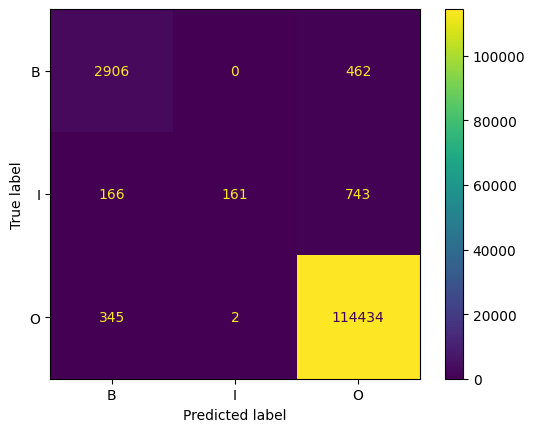

In [67]:
cm = confusion_matrix(targets,preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm[1:,1:],display_labels = ['B', 'I', 'O'])
disp.plot()

In [68]:
## Some manual testing

def get_skills(sentence_list):
    prediction = []
    token_list = []
    tag_list = []
    for sentence in sentence_list:
        if type(sentence) == str:
            doc = nlp(sentence)
            tokens = [str(i) for i in doc]
            output = ['O' for i in range(len(tokens))]
            tokens = tokens[:200]
            token_list.append(tokens)
            tag_list.append(output)
    dataset = prepare_dataset(token_list, tag_list)
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    preds = []
    for sent_batch, tag_batch in loader:
        tag_scores = model(sent_batch)
        tag_scores = tag_scores.argmax(axis=2).squeeze().tolist()
        preds = [IDX_TO_TAG[i] for i in tag_scores] 
        prediction.append(preds)
    #result = []
    
    entity_list = []
    for i, p in enumerate(prediction):
        tokens = token_list[i]
        entity = ''
        entities = []
        for j in range(len(p)):
            if p[j] == 'B':
                if entity != '':
                    entities.append(entity)
                entity = tokens[j]
            elif p[j] == 'I':
                if entity != '':
                    entity += ' '+tokens[j]
            else:
                if entity != '':
                    entities.append(entity)
                entity = ''
        entity_list.append(entities)
        
        #result.append([(t,j) for t, j in zip(tokens, p) if j in {'B', 'I'}])
    return  entity_list

sentence = ['We need someone who is good at Python and Java.',
            
'Good with machine learning. Excellent Azure knowledge. Good with data science and NLP',
            ]
for i,j in zip(sentence,get_skills(sentence)):
    print('Input:',i)
    print('Skills:',j)
    print()

Input: We need someone who is good at Python and Java.
Skills: []

Input: Good with machine learning. Excellent Azure knowledge. Good with data science and NLP
Skills: ['machine learning', 'data science']



In [73]:
sentence_list = [df['sentence'][i] for i in test_index if type(df['filtered_skills'][i])==str]
gold = [df['filtered_skills'][i] for i in test_index if type(df['sentence'][i])==str]

In [74]:
gold[-10:]

['business intelligence, requirements gathering, master data management, analytics, data models, reporting, integration, artificial intelligence, statistical analysis, data, data analytics',
 'dm, data management, documentation, data',
 'software, economics, data services, analytics, securities',
 'administration, software',
 nan,
 'data warehousing, database, data integrity, data marts, technical requirements, data analysis, diagrams, modeling, enterprise data, data',
 'language processing, data science, anomaly detection, optimization, security, forecasting, modeling, financial data, machine learning, unstructured data',
 'c, statistics',
 nan,
 'application development, coding practices, data quality, modeling, data models, reverse engineering, databases, sql, data']

In [75]:
predictions = get_skills(sentence_list)

In [76]:
predictions[-10:]

[['big', 'data', 'computer science', 'mathematics', 'physics', 'economics'],
 ['big', 'data', 'nosql', 'databases', 'exadata', 'hive', 'information'],
 ['data',
  'data',
  'integration',
  'business',
  'data',
  'analytics',
  'reporting',
  'master',
  'data',
  'analytics',
  'statistical',
  'artificial',
  'analytics',
  'data'],
 ['data', 'documentation'],
 ['economics', 'data', 'securities', 'analytics', 'software'],
 ['administration', 'software'],
 ['data',
  'data',
  'data',
  'technical',
  'enterprise',
  'data',
  'database',
  'data',
  'modeling',
  'enterprise',
  'enterprise',
  'enterprise',
  'data',
  'data',
  'data',
  'modeling',
  'diagrams',
  'modeling',
  'data',
  'modeling'],
 ['data science',
  'machine',
  'data science',
  'language',
  'security',
  'anomaly',
  'optimization',
  'forecasting',
  'financial',
  'modeling',
  'unstructured'],
 ['administration', 'public', 'administration', 'statistics'],
 ['data',
  'modeling',
  'data',
  'data',
  'a